# Task 3
## PROTEIN MUTATION CLASSIFICATION
### Introduction
Proteins are large molecules. Their blueprints are encoded in the DNA of biological organisms. Each protein consists of many amino acids: for example, our protein of interest consists of a little less than 400 amino acids. Once the protein is created (synthesized), it folds into a 3D structure, which can be seen in Figure 1. The mutations influence what amino acids make up the protein, and hence have an effect on its shape.
### Task
The goal of this task is to classify mutations of a human antibody protein into active (1) and inactive (0) based on the provided mutation information. Under active mutations the protein retains its original function, and inactive mutation cause the protein to lose its function. The mutations differ from each other by 4 amino acids in 4 respective sites. The sites or locations of the mutations are fixed. The amino acids at the 4 mutation sites are given as 4-letter combinations, where each letter denotes the amino acid at the corresponding mutation site. Amino acids at other places are kept the same and are not provided.
For example, FCDI corresponds to amino acid F (Phenylanine) being in the first site, amino acid C (Cysteine) being in the second site and so on. The Figure 2 gives translation from symbols to amino acid chemical names for the interested students. The biological and chemical aspects can be abstracted to solve this task.
### Dataset description
The handout you download contains the following files: 

* train.csv training set
* test.csv test set
* sample.csv a sample submission file in the correct format

Each line in train.csv corresponds to a single mutation. The dataset contains 112000 rows, where each row is associated with a mutation described by a sequence of four letters (amino acids) and its activity (label).
 
| Sequence | Active |
|----------|--------|
| DKVL     | 0      |
| FCHN     | 0      |
| ...      | ...    |
| LCLA     | 1      |
| ...      | ...    |

The test.csv has the same structure, however the column for activity is omitted.
You should submit a csv file containing the predicted activity of mutations in the same order as in the test set. The csv should contain only 0 or 1 in each separate line. For your convenience, we provide a sample submission file which has been generate randomly.

### EVALUATION

For the practical purposes, it is very important to detect nearly all active mutations such that they can be evaluated. Hence we need to maximize recall (true positive rate), but at the same time we want to have equally good precision. Therefore, we use F1 score which captures both precision and recall. The formula to calculate it is:
$$F1 = 2 ⋅ \frac{precision * recall}{precision + recall}$$
To calculate the F1 score we use scikit-learn implementation:
 ```
 from sklearn.metrics import f1_score
 f1_score(y_true, y_predicted)
 ```
  


### Preprocessing

In the following, we will first import all the relevant modules as well as 3 external codes.
- ```task3```, implements the preprocessing as well as a few useful functions
- ```our_model```, used for the implementation of a pytorch Neural Network
- ```rnn_model```, used for a recurrent neural network implementation

In [1]:
import numpy as np
import pandas as pd
import task3
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
import importlib
import our_model
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import rnn_model

# True to try out a model, i.e. Split the labeled data into a training and a test set
# False to train a model with the full training set therefore no score on our model can be computed
split = False

# True if we load the data from files (takes a bit less than a minute to prepare the data)
# False if we want to prepare the data and store it into separate files for later
load = False

# 1 for Neural network with scikit
# 2 for Deep Neural Network with pytorch
# 3 for Recurrent Neural Network
model_to_use = 1

In [3]:
importlib.reload(task3)

training_set = pd.read_csv('data/train.csv')
test_set = pd.read_csv('data/test.csv')

if load:
    transformed_training_set = pd.read_csv('data/transformed_training_set.csv')
    transformed_test_set = pd.read_csv('data/transformed_test_set.csv')
else:
    transformed_training_set = task3.transformInput(training_set)
    transformed_training_set.to_csv('data/transformed_training_set.csv', index = False)
    transformed_test_set = task3.transformInput(test_set, test = True)
    transformed_test_set.to_csv('data/transformed_test_set.csv', index = False)

finished processing index  110000
finished processing index  40000


In [81]:
train_labels = transformed_training_set['Active'].values.astype(np.float32)
train_features = transformed_training_set.drop('Active', axis = 1).values.astype(np.float32)

In [82]:
batch_size = 1000
import math

train_target = torch.tensor(transformed_training_set['Active'].values.astype(np.float32)).reshape((-1,1))
train_features = torch.tensor(transformed_training_set.drop('Active', axis = 1).values.astype(np.float32))
training_dataset = TensorDataset(train_features, train_target)
test_tensor = torch.tensor(transformed_test_set.values.astype(np.float32))

if split:
    length = train_features.size()[0]
    training_dataset, test_dataset = random_split(training_dataset, [math.floor(length*0.8), math.ceil(length*0.2)])
train_loader = DataLoader(dataset = training_dataset, batch_size = batch_size, shuffle = True)

print(train_features.size())
print(train_target.size())
print(test_tensor.size())

torch.Size([224000, 84])
torch.Size([224000, 1])
torch.Size([48000, 84])


In [83]:
from torch.optim import SGD


importlib.reload(our_model)
torch.manual_seed(1)  # for initialization repro
#net = our_model.Net().to(device)

device = "cuda" if torch.cuda.is_available() else "cpu"

print("Using {} device".format(device))

# get model from our_model.py
del model
model = our_model.Net().to(device)
# the model outputs real numbers. so we use the follosing loss function
# this loss function applies the sigmoid and then does binary cross entropy
# the pos_weight means that errors are scaled when y should have been 1
weight = torch.Tensor([1.5])
criterion = torch.nn.BCEWithLogitsLoss(reduction='mean', pos_weight=weight)
# our optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Using cpu device


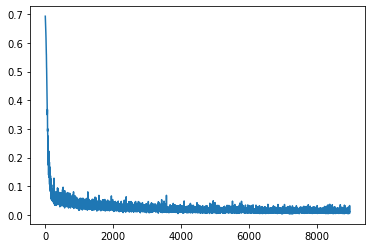

In [84]:
# set the model to train mode
model.train()
# for the plot, keep a list of all errors
losses = list()
for epoch in range(40): # loop over the dataset multiple times
    running_loss = 0
    train_loader = DataLoader(dataset = training_dataset, batch_size = batch_size, shuffle = True)
    for idx, batch in enumerate(train_loader): # look at all batches
        features, labels = batch
        features = features.to(device)
        labels = labels.to(device)
        # set the gradient to zero after last iteration
        optimizer.zero_grad()

        # compute output and step backwards
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # for bookkeeping
        losses.append(loss)
        running_loss = loss

    print(f'Epoch %.d finished with loss %1.6f' % (epoch, running_loss), end='\r')

plt.plot(losses)
torch.save(model.state_dict(), 'model_weights.pth')

In [77]:
# set the model to evaluation mode
model.eval()
# get the test dataset into one batch
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))
# we iterate over it but there is only one batch
for index, data in enumerate(test_loader):
    features, labels = data
    # this will speed up forward compuation because it does not keep the gradients
    with torch.no_grad():
        out = model(features)
        pred = torch.sigmoid(out)


In [78]:

values = pred.numpy()
# make the values from sigmoid to actual predictions
predicted_labels = np.heaviside(values-0.5,0)
y_true = labels.numpy().ravel()
y_pred = predicted_labels.ravel()
# this prints how many predictions = 1 are in each vector
print(sum(y_true))
print(sum(y_pred))
score = f1_score(y_true,y_pred)
print(score)


859.0
891.0
0.8491428571428572


In [86]:
import pandas as pd
model.eval()
with torch.no_grad():
    out = model(test_tensor)
pred = torch.sigmoid(out)
values = pred.numpy()
predicted_labels = np.heaviside(values-0.5,0)
y_pred = predicted_labels.ravel()
df = pd.DataFrame(y_pred)
print(df.shape)
df.to_csv('submission.csv', index=False, header=False)

(48000, 1)


In [ ]:
del test_set
del test_loader